<a href="https://colab.research.google.com/github/JinseongP/Basic-AI/blob/main/day5/5_1_time_series_prediction_with_deep_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: https://github.com/SLCFLAB/Data-Science-Python

# Time Series Prediction with Deep Learning Models

You will now practice using deep learning models(RNN, LSTM, 1D CNN) to predict future values using past values. For your assignment, please change parameters, model structures and apply new model to shampoo data.

Reference:
* https://github.com/hee9joon/Univariate-Time-Series-Prediction-using-Deep-Learning.   
*  https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [ ]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2022-05-02 09:32:39--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv’

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2022-05-02 09:32:40 (33.9 MB/s) - ‘shampoo.csv’ saved [519/519]



In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2022-08-25 01:04:05--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-08-25 01:04:05 (36.0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

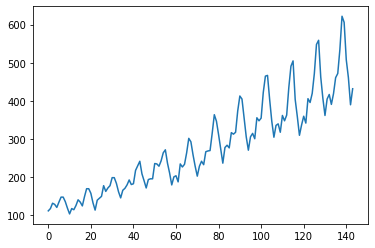

In [3]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [5]:
class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [6]:
class RNN(nn.Module):
    # Vanilla RNN
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        batch_size = x.size(0)

        # initialize hidden state for first input
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # pass model input and hidden state
        h_out, hidden = self.rnn(x, hidden.detach())
        
        h_out = h_out[:,-1,:]
        #h_out = h_out.contiguous().view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [7]:
class CNN(nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, hidden_dim, output_size):
        super(CNN, self).__init__()

        self.main = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=hidden_dim, kernel_size=1),
            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(hidden_dim, 10),
            nn.Linear(10, output_size)
        )

    def forward(self, x):
        out = self.main(x)
        return out

## Training

In [8]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.34297
Epoch: 100, loss: 0.00969
Epoch: 200, loss: 0.00346
Epoch: 300, loss: 0.00277
Epoch: 400, loss: 0.00222
Epoch: 500, loss: 0.00187
Epoch: 600, loss: 0.00168
Epoch: 700, loss: 0.00166
Epoch: 800, loss: 0.00165
Epoch: 900, loss: 0.00165
Epoch: 1000, loss: 0.00164
Epoch: 1100, loss: 0.00163
Epoch: 1200, loss: 0.00162
Epoch: 1300, loss: 0.00161
Epoch: 1400, loss: 0.00160
Epoch: 1500, loss: 0.00159
Epoch: 1600, loss: 0.00158
Epoch: 1700, loss: 0.00158
Epoch: 1800, loss: 0.00157
Epoch: 1900, loss: 0.00157


## Testing for Airplane Passengers Dataset

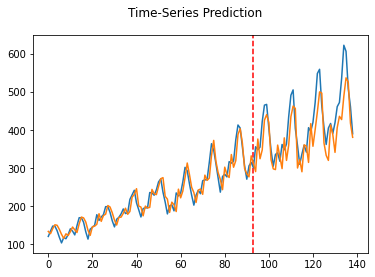

In [9]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Exercise
Vanilla RNN, 1D CNN models로 train code와 test code를 작성해보세요.